In [1]:
# --------------- #
# Import Packages #
# --------------- #

# --- Base packages ---
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd

# --- Visualisation packages ---
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import altair as alt
from pandas.plotting import parallel_coordinates
import plotly.express as px

# --- Statistical packages ---
import math
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# --- Mainly to supress Altair's warnings ---
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **RQ3**: _What are the district characteristics associated with variations in crime?_

---

## A. Preliminaries

### A.1. Restructure the Data

In [2]:
# Import pre-processed census data.
main_df_pre = pd.read_csv("data/0_main_df_pre.csv")
main_df_pre_mod = main_df_pre.copy()
main_df_pre_mod = main_df_pre_mod.drop(columns=main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('age')])
main_df_pre_mod['age_00_09'] = main_df_pre['age_00_04'] + main_df_pre['age_05_09']
main_df_pre_mod['age_10_19'] = main_df_pre['age_10_14'] + main_df_pre['age_15_19']
main_df_pre_mod['age_20_29'] = main_df_pre['age_20_24'] + main_df_pre['age_25_29']
main_df_pre_mod['age_30_39'] = main_df_pre['age_30_34'] + main_df_pre['age_35_39']
main_df_pre_mod['age_40_49'] = main_df_pre['age_40_44'] + main_df_pre['age_45_49']
main_df_pre_mod['age_50_59'] = main_df_pre['age_50_54'] + main_df_pre['age_55_59']
main_df_pre_mod['age_60_69'] = main_df_pre['age_60_64'] + main_df_pre['age_65_69']
main_df_pre_mod['age_70+'] = main_df_pre['age_70_74'] + main_df_pre['age_75_79'] + main_df_pre['age_80_84'] + main_df_pre['age_85+']
main_df_pre_mod = main_df_pre_mod.set_index(['state', 'district']).sort_index()

main_df_post = pd.read_csv("data/0_main_df_post.csv")
main_df_post_mod = main_df_post.copy()
main_df_post_mod = main_df_post_mod.drop(columns=main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('age')])
main_df_post_mod['age_00_09'] = main_df_post['age_00_04'] + main_df_post['age_05_09']
main_df_post_mod['age_10_19'] = main_df_post['age_10_14'] + main_df_post['age_15_19']
main_df_post_mod['age_20_29'] = main_df_post['age_20_24'] + main_df_post['age_25_29']
main_df_post_mod['age_30_39'] = main_df_post['age_30_34'] + main_df_post['age_35_39']
main_df_post_mod['age_40_49'] = main_df_post['age_40_44'] + main_df_post['age_45_49']
main_df_post_mod['age_50_59'] = main_df_post['age_50_54'] + main_df_post['age_55_59']
main_df_post_mod['age_60_69'] = main_df_post['age_60_64'] + main_df_post['age_65_69']
main_df_post_mod['age_70+'] = main_df_post['age_70_74'] + main_df_post['age_75_79'] + main_df_post['age_80_84'] + main_df_post['age_85+']
main_df_post_mod = main_df_post_mod.set_index(['state', 'district']).sort_index()


# Select and normalise variables by district population
main_df_pre_norm = main_df_pre_mod[['population']]
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[['population']] / main_df_pre_mod[['population']].sum(), on=['state', 'district'], suffixes=('', '_share'))                                               # Share of total population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('crime')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])           # Crime per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[['rate_births', 'rate_deaths']], on=['state', 'district'])                                                                                                # Births and deaths per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('sex')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])             # Proportion of population by gender
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('age')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])             # Proportion of population by age group
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('ethnic')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])          # Proportion of population by age group
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('income')]], on=['state', 'district'])                                                     # Mean/median income and inequality
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('poverty')]], on=['state', 'district'])                                                    # Poverty rate
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[['p_rate', 'u_rate', 'ep_ratio']], on=['state', 'district'])                                                                                              # Labour force data
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('edu')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])             # Students per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('teach')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])           # Teachers per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('school')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])          # Schools per '000 population

main_df_post_norm = main_df_post_mod[['population']]
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[['population']] / main_df_post_mod[['population']].sum(), on=['state', 'district'], suffixes=('', '_share'))                                           # Share of total population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('crime')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])     # Crime per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[['rate_births', 'rate_deaths']], on=['state', 'district'])                                                                                             # Births and deaths per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('sex')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])       # Proportion of population by gender
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('age')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])       # Proportion of population by age group
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('ethnic')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])    # Proportion of population by age group
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('income')]], on=['state', 'district'])                                                # Mean/median income and inequality
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('poverty')]], on=['state', 'district'])                                               # Poverty rate
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[['p_rate', 'u_rate', 'ep_ratio']], on=['state', 'district'])                                                                                           # Labour force data
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('edu')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])       # Students per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('teach')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])     # Teachers per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('school')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])    # Schools per '000 population

# Import geo data.
district_boundaries = gpd.read_file('data/district_boundaries.shp')

# Only use values in shapefiles
dfPre = main_df_pre_norm.reset_index()[main_df_pre_norm.reset_index()['district'].isin(district_boundaries.district)]
dfPost = main_df_post_norm.reset_index()[main_df_post_norm.reset_index()['district'].isin(district_boundaries.district)]

# Create East and West Malaysia tag
dfPre['location'] = dfPre['state'].apply(lambda x: 'East Malaysia' if np.isin(x, ['Sabah', 'Sarawak', 'W.P. Labuan']) else 'West Malaysia')
dfPost['location'] = dfPost['state'].apply(lambda x: 'East Malaysia' if np.isin(x, ['Sabah', 'Sarawak', 'W.P. Labuan']) else 'West Malaysia')

# Set index
dfPre = dfPre.set_index(['location', 'state', 'district']).sort_index()
dfPost = dfPost.set_index(['location', 'state', 'district']).sort_index()

# Drop missing values.
dfPre = dfPre.dropna()
dfPost = dfPost.dropna()

# Filter West Malaysia only
dfPre = dfPre.loc['West Malaysia'].copy()
dfPost = dfPost.loc['West Malaysia'].copy()

### A.2. Define Helper Functions
- getColor: Retrieves the relevant colour associated with the location in the two-dimensional embedding space.
- cluster_helper: Standardises the data. Then helps to determine the optimal number of clusters by visualising the elbow method (within-cluster-sum-of-squartes) and silhoutte score(average intra-cluster distance).
- cluster_inspect: Standardises the data. Then visualises the silhoutte plots and spatial distribution of the clusters.

In [ ]:
# ---------------- #
# Helper Functions #
# ---------------- #

def getColor(x, y, minX, maxX, minY, maxY):
    """
    Retrieves the relevant colour associated with the location in the two-dimensional embedding space.
    """
    wX=maxX-minX 
    wY=maxY-minY
    rr=y-minY 
    cc=x-minX
    if (wY < wX):   # scale vertically (i.e. modify rr) to make it a square
        rr *= wX/wY  
    else:           # scale horizontally (i.e. modify cc) to make it a square
        cc *= wY/wX
    maxD=max(wX,wY) # length of the 'square'
    rr1=maxD-rr     # distance from opposite end on the horizontal axis
    cc1=maxD-cc     # distance from opposite end on the vertical axis

    # List of distances from the various four corners
    dc=[math.sqrt(rr*rr+cc*cc), math.sqrt(rr*rr+cc1*cc1), math.sqrt(rr1*rr1+cc*cc), math.sqrt(rr1*rr1+cc1*cc1)]
    weights=[0.0, 0.0, 0.0, 0.0]
    for i in range(len(weights)):
        weights[i]=(maxD-dc[i])/maxD
        if (weights[i]<0):
            weights[i]=0

    # Set the RGB values for the four corners
    reds=[228, 25, 255, 37]
    greens=[220, 228, 18, 13]
    blues=[0, 218, 6, 252]
    
    # Initialise RGB values = 0
    dr=0
    dg=0
    db=0

    # Calculate RGB values and cap at 255
    for i, weight in enumerate(weights):
        dr += weight*reds[i]
        dg += weight*greens[i]
        db += weight*blues[i]
    if (dr>255):
        dr=255
    if (dg>255):
        dg=255        
    if (db>255):
        db=255  

    # Create and return the relevant hex code
    c_string = '#{:02x}{:02x}{:02x}'.format(int(dr),int(dg),int(db))    
    return c_string



def cluster_helper(data, k_min, k_max, c_random_state=42, c_n_init='auto', c_max_iter=300, data_title=''):
    """
    Helps to determine the optimal number of clusters by visualising the elbow
    method (within-cluster-sum-of-squartes) and silhoutte score (average intra-
    cluster distance).
    """
    # Standardise the data
    scale = StandardScaler()
    data_scaled = scale.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

    # Determine the optimal number of clusters using the elbow method (within-cluster-sum-of-squartes) and silhoutte score(average intra-cluster distance)
    wcss = []
    silhouette_scores = []
    k_range = range(k_min, k_max+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=c_random_state, n_init=c_n_init, max_iter=c_max_iter)
        cluster_labels = kmeans.fit_predict(data_scaled)
        wcss.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Visualise the results
    plt.figure(figsize=(13, 4))

    # Plot the elbow curve
    plt.subplot(1, 2, 1)
    plt.plot(k_range, wcss, marker='o', linestyle='--', linewidth=1)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k '+ data_title)

    # Plot the silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, marker='o', color='green', linestyle='--', linewidth=1)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Optimal k '+ data_title)

    plt.tight_layout()
    plt.show()

    return None



def cluster_inspect(data, geo_data, k_list, c_random_state=42, c_n_init='auto', c_max_iter=300):
    """
    Visualises the silhoutte plots and spatial distribution of the clusters.
    """
    range_k = k_list
    cluster_df = {}

    # Standardise the data
    scale = StandardScaler()
    data_scaled = scale.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)
    
    for k in range_k:
        # Implement clustering
        kmeans = KMeans(n_clusters=k, random_state=c_random_state, n_init=c_n_init, max_iter=c_max_iter)
        cluster_labels = kmeans.fit_predict(data_scaled)
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)
        print("For n_clusters =", k, ", the average silhouette_score is :",silhouette_avg)

        lab_df = pd.DataFrame(cluster_labels, columns=['label'], index=data_scaled.index)
        lab_df_geo = pd.merge(geo_data, lab_df.reset_index(), on='district')

        # Plot the results
        fig, axs = plt.subplots(1,2, figsize=(20,5))

        y_lower = 3
        c_list = []
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / k)
            c_list.append(color)
            axs[0].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7
            )
            axs[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 3
        axs[0].set_title("The silhouette plot for the various clusters")
        axs[0].set_xlabel("The silhouette coefficient values")
        axs[0].set_ylabel("Cluster label")
        axs[0].axvline(x=silhouette_avg, color="red", linestyle="--")
        axs[0].set_yticks([])
        axs[0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        custom_cmap = ListedColormap(c_list)
        
        df_scaled = data_scaled.copy()  # Create a copy so that the insertion of label column does not affect the original dataset.
        df_scaled.insert(0, 'label', lab_df)
        name = "cluster_" + str(k)
        cluster_df[name] = df_scaled

        lab_df_geo.plot(ax=axs[1], column='label', cmap=custom_cmap)
        axs[1].set_xticks([])
        axs[1].set_yticks([])

        plt.show()

        data_scaled_pcp = df_scaled.copy()
        data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("crime_", "")
        data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("assault_", "a_")
        data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("property_", "p_")
        fig = px.parallel_coordinates(data_scaled_pcp.reset_index(drop=True),
                                      color="label",
                                      color_continuous_scale='jet')
        filename = f"RQ2_2_parallel_coordinates_plot_{name}.html"
        #fig.write_html(filename)
        #fig.show()

    return cluster_df

## B. Explore Clustering Districts

### B.1. Pre-process Dataset
Only focus on total crime, and characteristics with high correlation to crime.

In [4]:
# Create df: total crime
dfPreTotal = dfPre.drop(['population', 'population_share', 'crime_assault', 'crime_property'], axis=1)
dfPostTotal = dfPost.drop(['population', 'population_share', 'crime_assault', 'crime_property'], axis=1)

# Identify columns to drop.
col_to_drop = list(dfPreTotal.columns[dfPreTotal.columns.str.startswith('rate') + dfPreTotal.columns.str.startswith('edu') + dfPreTotal.columns.isin(['sex_female', 'school_tertiary', 'school_total'])])
dfPreTotal_mod = dfPreTotal.drop(col_to_drop, axis=1)
dfPostTotal_mod = dfPostTotal.drop(col_to_drop, axis=1)

### B.2. Clustering - Elbow Method

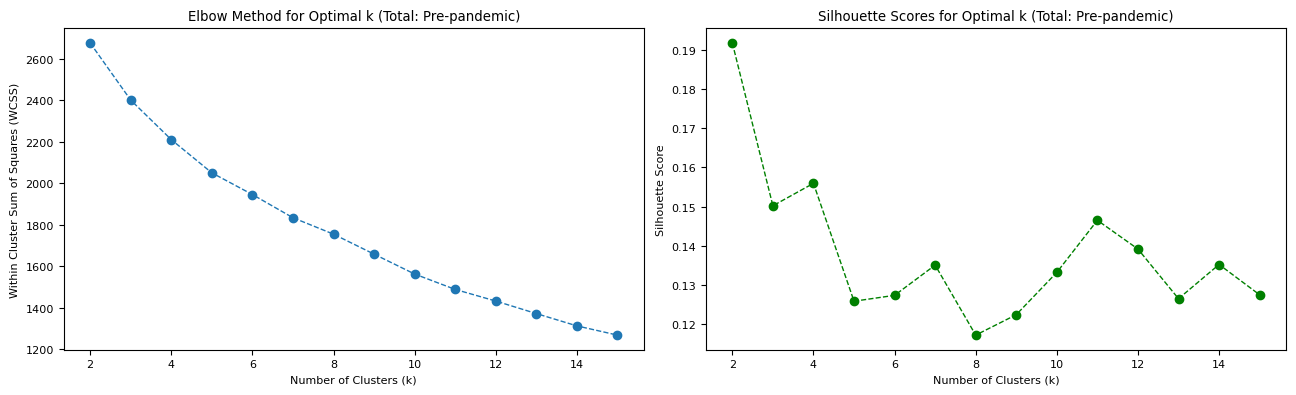

In [5]:
cluster_helper(dfPreTotal_mod, 2, 15, c_random_state=42, c_n_init=2500, c_max_iter=10000, data_title='(Total: Pre-pandemic)')

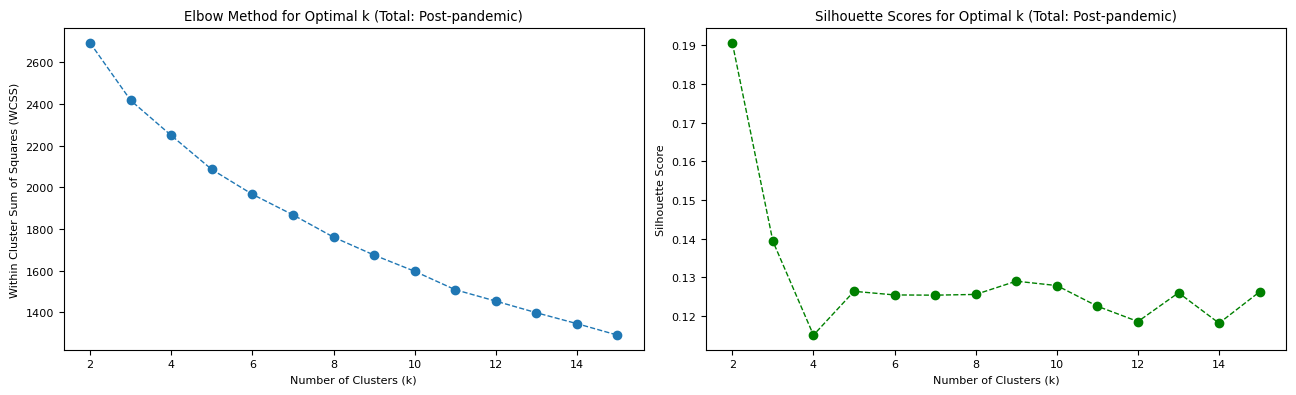

In [6]:
cluster_helper(dfPostTotal_mod, 2, 15, c_random_state=42, c_n_init=2500, c_max_iter=10000, data_title='(Total: Post-pandemic)')

### B.3. Clustering - Silhoutte Score

For n_clusters = 3 , the average silhouette_score is : 0.13930794919275297


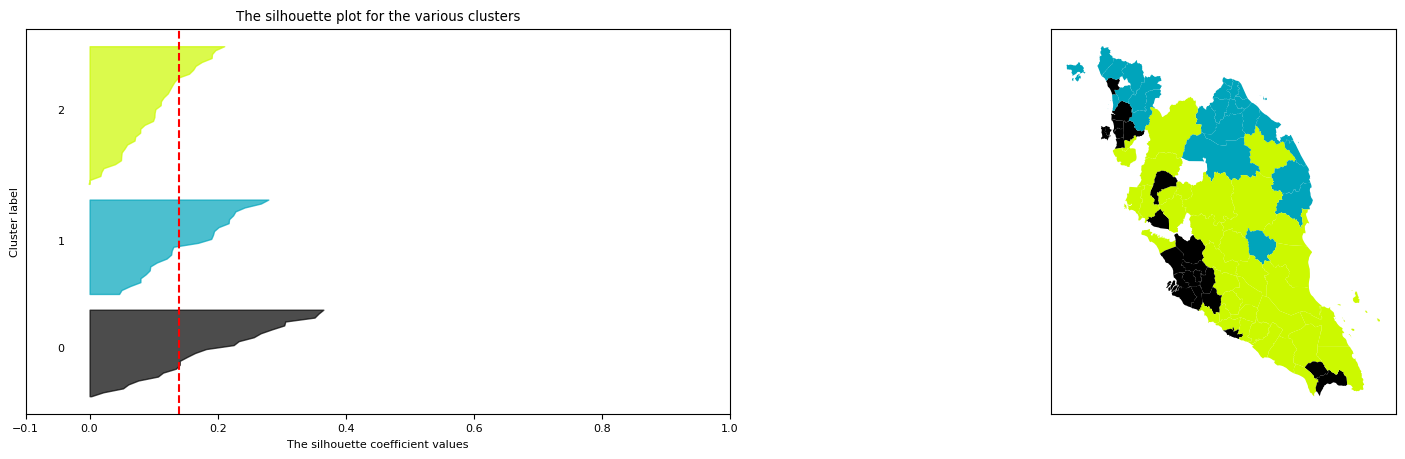

For n_clusters = 4 , the average silhouette_score is : 0.11505851199626049


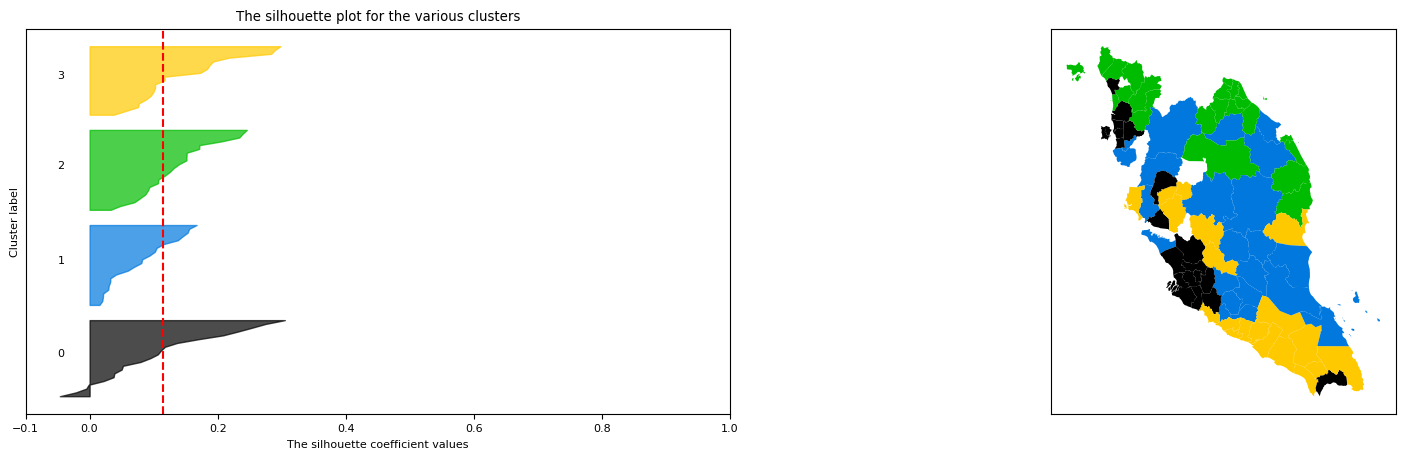

For n_clusters = 5 , the average silhouette_score is : 0.1263769801273263


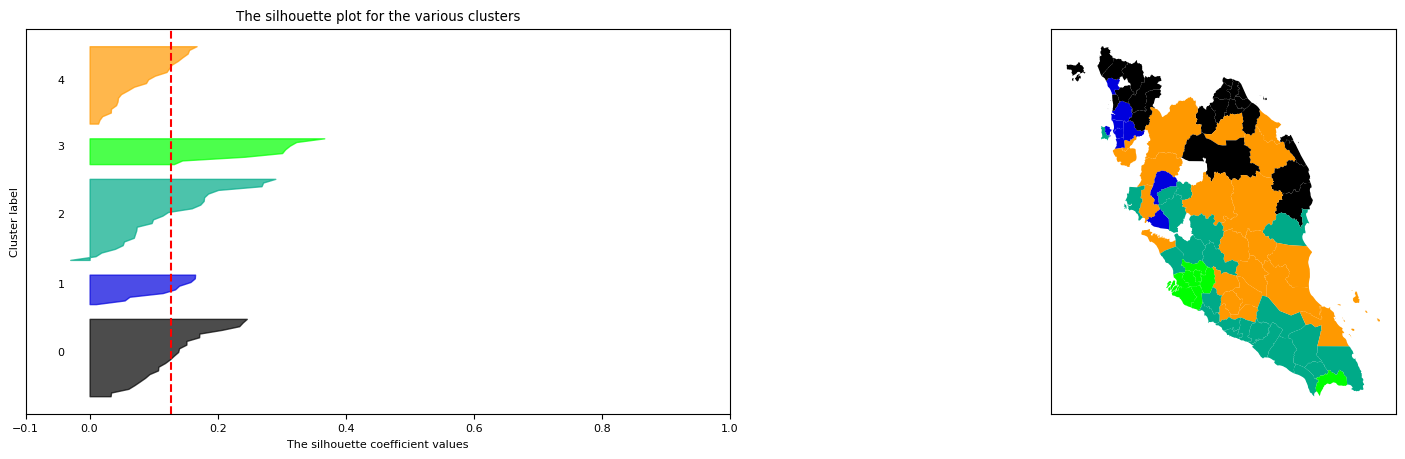

In [7]:
clusters_df_postTotal = cluster_inspect(dfPostTotal_mod, district_boundaries, [3, 4, 5], c_random_state=42, c_n_init=2500, c_max_iter=10000)